In [1]:
import pandas as pd
import functions as fn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Start from 01-01-2018 and end at 12-31-2018
qqq2018 = pd.read_csv("../data/qqqMinute2018.csv")
has2018 = pd.read_csv("../data/hasMinute2018.csv")

In [3]:
qqq2018 = qqq2018.set_index('date_time')
qqq2018 = qqq2018.rename(columns={'close': 'qqqclose'})

has2018 = has2018.set_index('date_time')
has2018 = has2018.rename(columns={'close': 'hasclose'})

In [4]:
c_basket_data2018 = qqq2018[['qqqclose']].join(has2018[['hasclose']])
c_basket_data2018 = c_basket_data2018.dropna()
c_basket_data2018.index.rename("datetime", inplace=True)
c_basket_data2018.tail(10)

,qqqclose,hasclose
datetime,,
2018-12-31 15:40:00,153.7400,81.2300
2018-12-31 15:41:00,153.8144,81.2800
2018-12-31 15:42:00,153.8100,81.3309
2018-12-31 15:43:00,153.8500,81.2500
2018-12-31 15:44:00,153.7760,81.2350
2018-12-31 15:45:00,153.7900,81.2500
2018-12-31 15:46:00,153.7700,81.2100
2018-12-31 15:47:00,153.6800,81.1400
2018-12-31 15:48:00,153.5750,81.0300


In [5]:
lookback_list = np.arange(30, 301, 30)
z_thresh_list = np.arange(1, 2.6, .25)
results_map_c = fn.tuneBBParameters(c_basket_data2018, lookback_list, z_thresh_list, ['hasclose'], stoploss = None)

C:\Users\liuvi\Documents\fall2020\f20_stat_arb\functions.py:346: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data['logspread'] = spread_ts
C:\Users\liuvi\Documents\fall2020\f20_stat_arb\functions.py:347: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data['spread'] = np.exp(spread_ts)
C:\Users\liuvi\Documents\fall2020\f20_stat_arb\functions.py:348: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


10 done, out of 70
20 done, out of 70
30 done, out of 70
40 done, out of 70
50 done, out of 70
60 done, out of 70
70 done, out of 70


In [6]:
print("HAS Spread Dynamic Strategy Parameters \n")
params_c = list(results_map_c.keys())[0]
print("Lookback: ", params_c[0])
print("Z-Score Threshold: ", params_c[1])

HAS Spread Dynamic Strategy Parameters 

Lookback:  30
Z-Score Threshold:  1.75


In [7]:
syntheticAssetLogPriceC2018 = c_basket_data2018[['hasclose']].apply(np.log)
qqqLogPriceC2018 = np.log(c_basket_data2018['qqqclose'].values)
kf_c2018 = fn.univariateKalmanFilter(syntheticAssetLogPriceC2018.values, qqqLogPriceC2018)
state_means_c2018, state_covs_c2018 = kf_c2018.filter(qqqLogPriceC2018)
slopes_c2018 = state_means_c2018[:, 0]
intercept_c2018 = state_means_c2018[:, 1]

In [8]:
syntheticAssetEstimateC2018 = [slopes_c2018[i] * syntheticAssetLogPriceC2018.values[:, 0][i] + intercept_c2018[i] 
                           for i in range(len(slopes_c2018))]
spread_ts_c2018 = qqqLogPriceC2018 - syntheticAssetEstimateC2018

c_basket_data2018.reset_index(inplace=True)
c_basket_data2018 = c_basket_data2018.rename(columns={'date_time': 'datetime'})
c_basket_data2018['logspread'] = spread_ts_c2018
c_basket_data2018['spread'] = np.exp(spread_ts_c2018)

c_basket_data2018 = c_basket_data2018[['datetime', 'qqqclose', 'hasclose', 'spread']]
diff_thresh_c = fn.calculateDiffThresh(c_basket_data2018, q=0.2)

In [9]:
print(diff_thresh_c)

0.01394209610319565


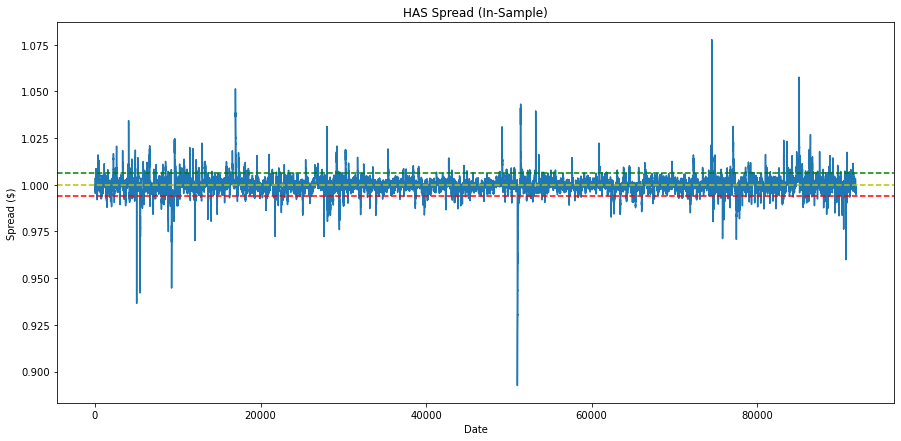

In [10]:
plt.figure(figsize = (15,7))
plt.plot(c_basket_data2018['spread'])
plt.title("HAS Spread (In-Sample)")
plt.ylabel("Spread ($)")
plt.xlabel("Date")
spread_avg_c = c_basket_data2018['spread'].mean()
spread_sd_c = c_basket_data2018['spread'].std()
c = 1.25
upper_threshold_c = spread_avg_c + c * spread_sd_c
lower_threshold_c = spread_avg_c - c * spread_sd_c
plt.axhline(upper_threshold_c, linestyle = 'dashed', color = 'g')
plt.axhline(spread_avg_c, linestyle = 'dashed', color = 'y')
plt.axhline(lower_threshold_c, linestyle = 'dashed', color = 'r')

In [11]:
print("HAS Spread Thresholds \n")
print("Mean: ", spread_avg_c)
print("Lower Bar: ", lower_threshold_c)
print("Upper Bar: ", upper_threshold_c)

HAS Spread Thresholds 

Mean:  1.0000692635271209
Lower Bar:  0.9939538662627763
Upper Bar:  1.0061846607914655


In [12]:
c_data = pd.read_csv("../data/c_basket_data.csv")

In [13]:
c_backtest_data = c_data[['datetime', 'qqqclose', 'hasclose', 'spread']]
c_backtest_data_static = fn.createBars(c_backtest_data.copy(), lower_threshold_c, upper_threshold_c, spread_avg_c)
c_backtest_data_dyn = fn.createBands(c_backtest_data.copy(), params_c[0], params_c[1])

Text(0.5, 0, 'Date')

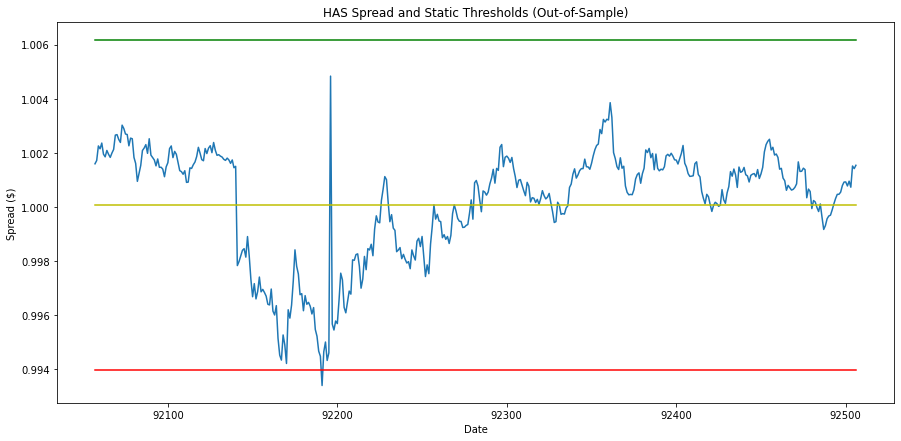

In [14]:
plt.figure(figsize = (15,7))
plt.plot(c_backtest_data_static['spread'].iloc[-450:])
plt.plot(c_backtest_data_static['upperband'].iloc[-450:], color='g')
plt.plot(c_backtest_data_static['ema'].iloc[-450:], color='y')
plt.plot(c_backtest_data_static['lowerband'].iloc[-450:], color='r')
plt.title("HAS Spread and Static Thresholds (Out-of-Sample)")
plt.ylabel("Spread ($)")
plt.xlabel("Date")

Text(0.5, 0, 'Date')

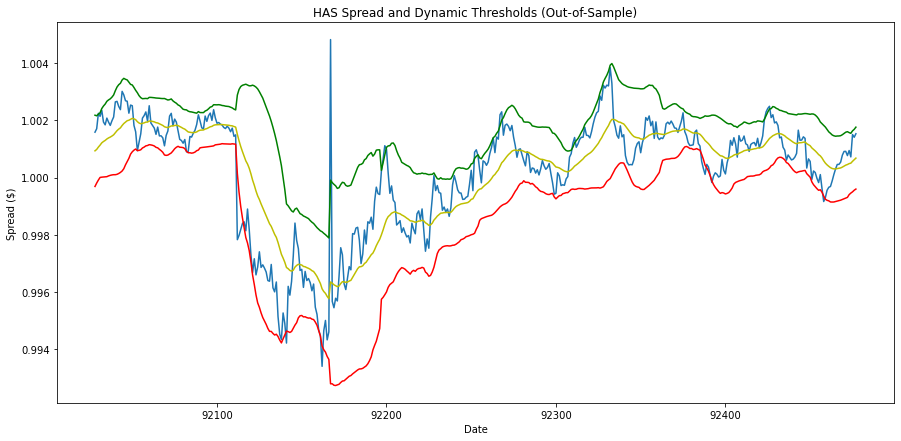

In [15]:
plt.figure(figsize = (15,7))
plt.plot(c_backtest_data_dyn['spread'].iloc[-450:])
plt.plot(c_backtest_data_dyn['upperband'].iloc[-450:], color='g')
plt.plot(c_backtest_data_dyn['ema'].iloc[-450:], color='y')
plt.plot(c_backtest_data_dyn['lowerband'].iloc[-450:], color='r')
plt.title("HAS Spread and Dynamic Thresholds (Out-of-Sample)")
plt.ylabel("Spread ($)")
plt.xlabel("Date")

In [16]:
c_final_data_static = fn.createPositions(c_backtest_data_static.copy()) # no overnight positions, all positions exited by EOD
c_final_data_opt_static = fn.createOptimalPositions(c_backtest_data_static.copy(), threshold=diff_thresh_c)

In [17]:
tradeLog_c, minuteDf_c = fn.constructTradeLog(c_final_data_static['datetime'].values, c_final_data_static['position'].values,
                               c_final_data_static['qqqclose'].values, c_final_data_static[['hasclose']].values, 
                               c_data[['hasSlope']].values.round(3), stoploss = None,
                               lot_size = 1000)
tradeLog_c.tail()

,start,end,holdingPeriod,position,positionSizeY,entryY,exitY,positionSizeX,entryX,exitX,initialPortfolioValue,trade_profit,trade_returns
302,2019-12-19 09:51:00,2019-12-19 10:04:00,13,long,1000,209.9600,209.9240,[1047.0],[104.02],[103.5],318868.94,508.4400,0.001595
303,2019-12-19 12:46:00,2019-12-19 14:12:00,86,long,1000,210.4000,210.5600,[1047.0],[104.42],[104.38],319727.74,201.8800,0.000631
304,2019-12-20 15:25:00,2019-12-20 15:50:00,25,short,1000,211.8299,211.6000,[1048.0],[103.66],[103.82],320465.58,397.5800,0.001241
305,2019-12-23 09:44:00,2019-12-23 10:33:00,49,long,1000,211.9200,211.8300,[1048.0],[104.75],[104.5828],321698.00,85.2256,0.000265
306,2019-12-31 10:32:00,2019-12-31 10:37:00,5,long,1000,211.7800,211.9248,[1044.0],[106.13],[106.12899999999999],322579.72,145.8440,0.000452


In [18]:
print("Average Holding Period: ", tradeLog_c['holdingPeriod'].mean())
tradeLog_c['dayPeriod'] = tradeLog_c['start'].dt.to_period("D")
print("Average Trades per Day: ", tradeLog_c.groupby('dayPeriod')['trade_profit'].count().mean())

Average Holding Period:  66.95114006514657
Average Trades per Day:  1.566326530612245


In [19]:
tradeLog_c_opt, minuteDf_c_opt = fn.constructTradeLog(c_final_data_opt_static['datetime'].values, c_final_data_opt_static['position'].values,
                               c_final_data_opt_static['qqqclose'].values, c_final_data_opt_static[['hasclose']].values, 
                               c_data[['hasSlope']].values.round(3), stoploss = None,
                               lot_size = 1000)
tradeLog_c_opt.tail()

,start,end,holdingPeriod,position,positionSizeY,entryY,exitY,positionSizeX,entryX,exitX,initialPortfolioValue,trade_profit,trade_returns
163,2019-12-10 09:52:00,2019-12-10 10:09:00,17,short,1000,204.0000,204.2300,[1050.0],[99.59],[100.2301],308569.5000,442.1050,0.001433
164,2019-12-12 12:50:00,2019-12-12 13:35:00,45,long,1000,205.8100,205.9317,[1049.0],[102.0174],[101.68],312826.2526,475.6326,0.001520
165,2019-12-13 10:12:00,2019-12-13 11:01:00,49,long,1000,207.8400,206.6936,[1046.0],[104.0463],[103.21],316672.4298,-271.6302,-0.000858
166,2019-12-13 13:07:00,2019-12-13 14:05:00,58,long,1000,207.4400,207.2800,[1045.0],[104.39],[104.04],316527.5500,205.7500,0.000650
167,2019-12-16 09:59:00,2019-12-16 12:04:00,125,short,1000,209.0682,209.4500,[1045.0],[103.845],[103.24],317586.2250,-1014.0250,-0.003193


In [20]:
print("Average Holding Period: ", tradeLog_c_opt['holdingPeriod'].mean())
tradeLog_c_opt['dayPeriod'] = tradeLog_c_opt['start'].dt.to_period("D")
print("Average Trades per Day: ", tradeLog_c_opt.groupby('dayPeriod')['trade_profit'].count().mean())

Average Holding Period:  77.61904761904762
Average Trades per Day:  1.2923076923076924


<ipython-input-21-80223854c894>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns_df_c['cumulative_returns'] = np.cumprod(1 + minuteDf_c['returns'])


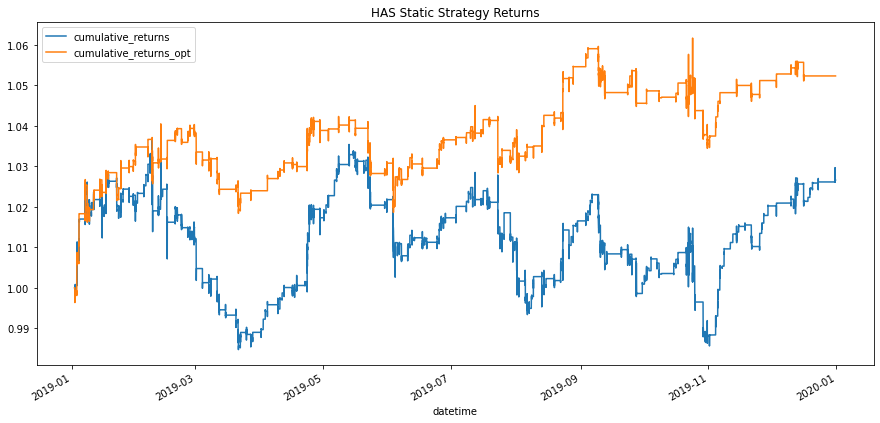

In [21]:
returns_df_c = minuteDf_c[['datetime']]
returns_df_c['cumulative_returns'] = np.cumprod(1 + minuteDf_c['returns'])
returns_df_c['cumulative_returns_opt'] = np.cumprod(1 + minuteDf_c_opt['returns'])
returns_df_c = returns_df_c.set_index('datetime')
returns_df_c.plot(figsize=[15, 7], title='HAS Static Strategy Returns')

In [22]:
daily_c = fn.calculateDailyReturns(minuteDf_c[['returns', 'datetime']])
daily_c_opt = fn.calculateDailyReturns(minuteDf_c_opt[['returns', 'datetime']])
sharpe_c = fn.calculateAnnualizedSharpeRatio(daily_c)
sharpe_c_opt = fn.calculateAnnualizedSharpeRatio(daily_c_opt)

In [23]:
print("HAS Backtest Results (Static)")
print("Returns: ", (returns_df_c['cumulative_returns'].iloc[-1] - 1) * 100, '%')
print("Returns (Optimized): ", (returns_df_c['cumulative_returns_opt'].iloc[-1] - 1) * 100, '%')
print("Sharpe: ", sharpe_c)
print("Sharpe (Optimized)", sharpe_c_opt)

HAS Backtest Results (Static)
Returns:  2.6605047822588324 %
Returns (Optimized):  5.23404907838092 %
Sharpe:  0.5520860608496807
Sharpe (Optimized) 1.3019330685750496


In [24]:
c_final_data_dyn = fn.createPositions(c_backtest_data_dyn.copy()) # no overnight positions, all positions exited by EOD
c_final_data_opt_dyn = fn.createOptimalPositions(c_backtest_data_dyn.copy(), threshold=diff_thresh_c)

C:\Users\liuvi\anaconda3\envs\quant\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [25]:
tradeLog_cd, minuteDf_cd = fn.constructTradeLog(c_final_data_dyn['datetime'].values, c_final_data_dyn['position'].values,
                               c_final_data_dyn['qqqclose'].values, c_final_data_dyn[['hasclose']].values, 
                               c_data[['hasSlope']].values.round(3), stoploss = None,
                               lot_size = 1000)
tradeLog_cd.tail()

,start,end,holdingPeriod,position,positionSizeY,entryY,exitY,positionSizeX,entryX,exitX,initialPortfolioValue,trade_profit,trade_returns
2821,2019-12-31 12:05:00,2019-12-31 12:30:00,25,short,1000,211.900,211.920,[1044.0],[105.8338],[105.779],322390.4872,-77.2112,-0.000239
2822,2019-12-31 13:03:00,2019-12-31 13:27:00,24,short,1000,211.945,211.980,[1044.0],[105.725],[105.59],322321.9000,-175.9400,-0.000546
2823,2019-12-31 14:19:00,2019-12-31 14:35:00,16,long,1000,211.960,212.170,[1044.0],[105.57],[105.56],322175.0800,220.4400,0.000684
2824,2019-12-31 14:57:00,2019-12-31 15:05:00,8,short,1000,212.165,212.275,[1044.0],[105.38],[105.5],322181.7200,15.2800,0.000047
2825,2019-12-31 15:31:00,2019-12-31 15:38:00,7,long,1000,212.330,212.385,[1044.0],[105.71],[105.62],322691.2400,148.9600,0.000462


In [26]:
print("Average Holding Period: ", tradeLog_cd['holdingPeriod'].mean())
tradeLog_cd['dayPeriod'] = tradeLog_cd['start'].dt.to_period("D")
print("Average Trades per Day: ", tradeLog_cd.groupby('dayPeriod')['trade_profit'].count().mean())

Average Holding Period:  14.436659589525831
Average Trades per Day:  11.214285714285714


In [27]:
tradeLog_cd_opt, minuteDf_cd_opt = fn.constructTradeLog(c_final_data_opt_dyn['datetime'].values, c_final_data_opt_dyn['position'].values,
                               c_final_data_opt_dyn['qqqclose'].values, c_final_data_opt_dyn[['hasclose']].values, 
                               c_data[['hasSlope']].values.round(3), stoploss = None,
                               lot_size = 1000)
tradeLog_cd_opt.tail()

,start,end,holdingPeriod,position,positionSizeY,entryY,exitY,positionSizeX,entryX,exitX,initialPortfolioValue,trade_profit,trade_returns
916,2019-12-30 10:22:00,2019-12-30 10:34:00,12,short,1000,211.630,211.5778,[1046.0],[104.8429],[104.89],321295.6734,101.4666,0.000316
917,2019-12-30 13:07:00,2019-12-30 13:09:00,2,short,1000,212.560,212.5266,[1044.0],[106.08],[106.1],323307.5200,54.2800,0.000168
918,2019-12-30 13:35:00,2019-12-30 14:02:00,26,short,1000,212.460,212.4350,[1044.0],[105.855],[105.744],322972.6200,-90.8840,-0.000281
919,2019-12-31 12:06:00,2019-12-31 12:30:00,24,short,1000,211.915,211.9200,[1044.0],[105.86],[105.779],322432.8400,-89.5640,-0.000278
920,2019-12-31 14:58:00,2019-12-31 15:05:00,7,short,1000,212.150,212.2750,[1044.0],[105.36],[105.5],322145.8400,21.1600,0.000066


In [28]:
print("Average Holding Period: ", tradeLog_c_opt['holdingPeriod'].mean())
tradeLog_c_opt['dayPeriod'] = tradeLog_c_opt['start'].dt.to_period("D")
print("Average Trades per Day: ", tradeLog_c_opt.groupby('dayPeriod')['trade_profit'].count().mean())

Average Holding Period:  77.61904761904762
Average Trades per Day:  1.2923076923076924


<ipython-input-29-8c3e729b34f4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns_df_c['cumulative_returns'] = np.cumprod(1 + minuteDf_c['returns'])


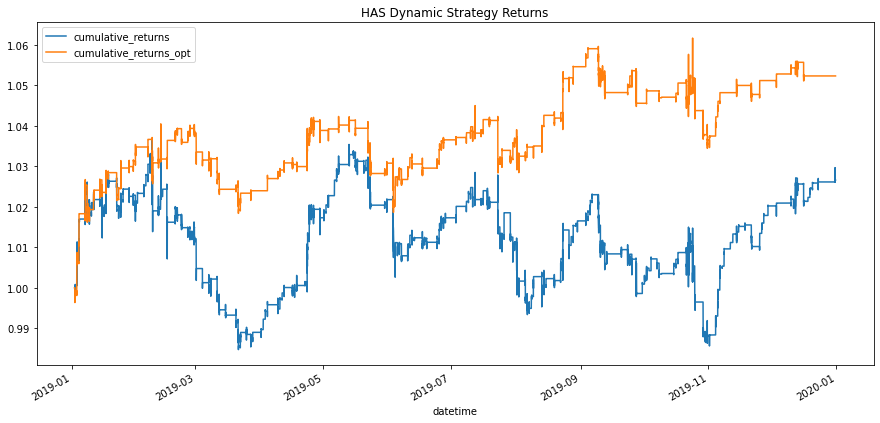

In [29]:
returns_df_c = minuteDf_c[['datetime']]
returns_df_c['cumulative_returns'] = np.cumprod(1 + minuteDf_c['returns'])
returns_df_c['cumulative_returns_opt'] = np.cumprod(1 + minuteDf_c_opt['returns'])
returns_df_c = returns_df_c.set_index('datetime')
returns_df_c.plot(figsize=[15, 7], title='HAS Dynamic Strategy Returns')

In [30]:
daily_c = fn.calculateDailyReturns(minuteDf_c[['returns', 'datetime']])
daily_c_opt = fn.calculateDailyReturns(minuteDf_c_opt[['returns', 'datetime']])
sharpe_c = fn.calculateAnnualizedSharpeRatio(daily_c)
sharpe_c_opt = fn.calculateAnnualizedSharpeRatio(daily_c_opt)

In [31]:
print("HAS Backtest Results (Dynamic)")
print("Returns: ", (returns_df_c['cumulative_returns'].iloc[-1] - 1) * 100, '%')
print("Returns (Optimized): ", (returns_df_c['cumulative_returns_opt'].iloc[-1] - 1) * 100, '%')
print("Sharpe: ", sharpe_c)
print("Sharpe (Optimized)", sharpe_c_opt)

HAS Backtest Results (Dynamic)
Returns:  2.6605047822588324 %
Returns (Optimized):  5.23404907838092 %
Sharpe:  0.5520860608496807
Sharpe (Optimized) 1.3019330685750496
